In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
from collections import OrderedDict
import cv2
import copy
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import point_cloud_utils as pcu
import torch
import torch.nn.functional as F
from skimage.transform import resize
from skimage.color import rgb2gray
from tqdm.notebook import tqdm as tqdm

import torch
import torchvision

import dense_correspondence_manipulation.utils.utils as utils

import meshcat
import meshcat.geometry as g

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.config import CfgNode as CN
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.data.datasets import load_coco_json
from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, launch
from detectron2.evaluation import inference_on_dataset, COCOEvaluator
from detectron2.modeling import build_model
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import scene_generation.inverse_graphics.synthetic_scene_database_loader as loader
from scene_generation.inverse_graphics.synthetic_scene_database_loader import XenRCNNMapper
import scene_generation.inverse_graphics.keypoint_mcmc.roi_heads as roi_heads
from scene_generation.inverse_graphics.keypoint_mcmc.particle_filter_icp import *

from pydrake.math import RigidTransform, RotationMatrix, RollPitchYaw
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

np.set_printoptions(precision=2)
torch.set_default_tensor_type(torch.FloatTensor)

DATA_ROOT = "/home/gizatt/data/generated_cardboard_envs/"
DETECTRON_ROOT = "/home/gizatt/tools/detectron2/"


class InstanceCloud():
    def __init__(self, pts, colors, descriptors):
        self.pts = pts
        self.descriptors = descriptors
        self.colors = colors
    def get_augmented_pts(self, descriptor_factor=1.):
        return np.vstack([self.pts, descriptor_factor*self.descriptors])
    
%matplotlib inline
def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

print(torchvision.__file__)

load_dict = torch.load("run_on_all_records.pt")
all_instance_clouds_by_record = load_dict["all_instance_clouds_by_record"]
affinities_by_record = load_dict["affinities_by_record"]
clusters_by_record = load_dict["clusters_by_record"]

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torchvision-0.6.0a0+fb562f5-py3.6-linux-x86_64.egg/torchvision/__init__.py


In [2]:
# Load in data into numpy and o3d structures.

import open3d as o3d
import copy
import matplotlib.cm as cm
import numpy as np

clusters = []
for c in list(clusters_by_record.values())[:10]:
    clusters += c
cluster = clusters[3]
    
vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")["scalar_field_fitting"]
vis.delete()

def compute_unit_box_descriptors(pts, normals):
    # Descriptor is the viridis color coding
    # of the distance to the center of each pt's face.
    face_local = np.abs(pts)*(normals == 0.0)*2
    dist = np.linalg.norm(face_local, axis=0)/1.414
    return torch.tensor(cm.get_cmap('viridis')(dist).astype(np.float32).T[:3, :])
    
# Make canonical box with descriptors
N_model_pts = 1000
model_pts, model_normals = make_unit_box_pts_and_normals(N=N_model_pts)
model_colors = np.zeros((3, model_pts.shape[1]))
model_colors[0, :] = 1.
model_descriptors = compute_unit_box_descriptors(model_pts, model_normals).numpy()
model_pts = np.dot(np.diag([0.5, 0.4, 0.3]), model_pts.numpy())
model_normals = model_normals.numpy()

scene_pts = cluster.pts.numpy()
scene_descriptors = cluster.descriptors.numpy()

def np_to_o3d(pts, colors, normals=None):
    pts_o3d = o3d.geometry.PointCloud()
    pts_o3d.points = o3d.utility.Vector3dVector(pts.copy().T)
    pts_o3d.colors = o3d.utility.Vector3dVector(colors.copy().T)
    if normals is not None:
        pts_o3d.normals = o3d.utility.Vector3dVector(normals.copy().T)
    else:
        pts_o3d.estimate_normals()
    return pts_o3d
scene_pts_o3d = np_to_o3d(scene_pts, scene_descriptors)
model_pts_o3d = np_to_o3d(model_pts, model_descriptors, model_normals)

# Clean up the input data
scene_pts_o3d, ind = scene_pts_o3d.remove_statistical_outlier(nb_neighbors=40,
                                                              std_ratio=1.0)
## And downsample some
N_scene_pts_before = np.asarray(scene_pts_o3d.points).shape[0]
scene_pts_o3d = scene_pts_o3d.voxel_down_sample(0.01)
N_scene_pts_after = np.asarray(scene_pts_o3d.points).shape[0]
print("Downsampled scene from %d pts to %d pts." % (N_scene_pts_before, N_scene_pts_after))
# Pre-generate kd trees that might be in use
scene_kdtree = o3d.geometry.KDTreeFlann(scene_pts_o3d)
model_kdtree = o3d.geometry.KDTreeFlann(model_pts_o3d)

vis["scene"].set_object(
    g.PointCloud(position=np.asarray(scene_pts_o3d.points).T,
                 color=np.asarray(scene_pts_o3d.colors).T,
                 size=0.01))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Downsampled scene from 31822 pts to 4858 pts.


In [7]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
def summarize_cloud_GMM(pts, max_num_components=48, **kwargs):
    # Summarize the given cloud with a gaussian mixture model
    num_components = min(pts.shape[1], max_num_components)
    gmm = GaussianMixture(n_components=num_components, **kwargs)
    gmm.fit(pts.T)
    kept_weights = (gmm.weights_ > 1E-4)
    #print("Num kept weights: %d / %d with %d pts" % (
    #    np.sum(kept_weights), num_components, pts.shape[1]))
    gmm.covariances_ = np.stack([np.eye(3)*0.01]*num_components, axis=0)
    gmm.weights_ = np.ones(num_components)
    return gmm
    
def select_inlier_scene_points_and_build_model_cloud(N_points = 5, thresh=0.05, max_num_components=48):
    # Pick N points from the scene...
    scene_pts_selection = []
    corresponding_model_clouds = []
    while len(scene_pts_selection) < N_points:
        scene_pt_ind = np.random.choice(N_scene_pts_after)
        scene_pt = scene_pts_o3d.points[scene_pt_ind]
        target_color = scene_pts_o3d.colors[scene_pt_ind]
        
        # For each point in the scene, get the corresponding model cloud
        # based on descriptor distance
        model_pt_mask = np.linalg.norm(model_descriptors.T - target_color, axis=1) < thresh
        if np.sum(model_pt_mask) > 0:
            scene_pts_selection.append(scene_pt)
            # Summarize 
            summarized_model_cloud = summarize_cloud_GMM(
                model_pts[:, model_pt_mask], max_num_components=max_num_components)
            corresponding_model_clouds.append(summarized_model_cloud)
    return np.stack(scene_pts_selection).T, corresponding_model_clouds

# Test it out with a single point
np.random.seed(1)
scene_pt_test, corresponded_model_cloud_test = select_inlier_scene_points_and_build_model_cloud(1, 0.1, 48)
print(scene_pt_test, corresponded_model_cloud_test)
vis["test"]["selected_scene_pt"].set_object(
    g.PointCloud(position=scene_pt_test,
                 color=np.array([1., 0., 0.]),
                 size=0.05))
gmm = corresponded_model_cloud_test[0]
kept_weights = gmm.weights_ > 1E-4
vis["test"]["model_gmm_centers"].set_object(
g.PointCloud(position=gmm.means_[kept_weights].T,
             color=np.array([[0., 1., 0.]]*np.sum(kept_weights)).T,
             size=0.05))
scores_by_model_pt = gmm.score_samples(model_pts.T)
scores_by_model_pt /=  np.max(scores_by_model_pt)
#scores_by_model_pt -= np.min(scores_by_model_pt)
#scores_by_model_pt /= np.max(scores_by_model_pt)
vis["test"]["model_pts_with_weight"].set_object(
g.PointCloud(position=model_pts,
             color=cm.get_cmap("jet")(scores_by_model_pt)[:, :3].T,
             size=0.02))

[[0.31]
 [0.07]
 [0.15]] [GaussianMixture(n_components=48)]


[235.48 318.97 284.86 245.12 245.5  351.03 271.81 213.02 287.42 265.42] [ 0.14  0.14 -0.8   0.6   0.58  0.76  0.35  0.6   0.69  0.26]
-109.5393024434873 5.967025684138855


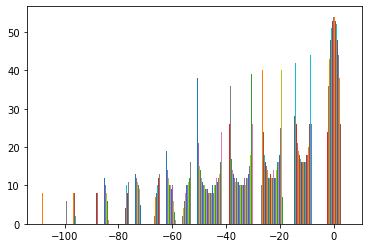

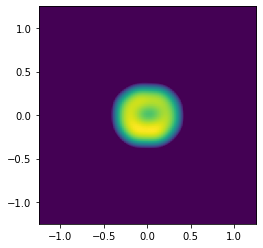

In [8]:
class MultivariateNormal():
    def __init__(self, mean, cov):
        self._dim = mean.shape[0]
        self._mean = mean
        self._cov = cov
        self._log_det_cov = np.log(np.linalg.det(self._cov))
        self._rank = np.linalg.matrix_rank(self._cov)
        assert self._rank == self._dim, (self._rank, self._dim)
        self._inv_cov = np.linalg.inv(self._cov)
    def logpdf(self, x):
        # Expect in dim x N
        assert x.shape[0] == self._dim, x.shape
        if len(x.shape) == 0:
            x = x[:, np.newaxis]
        dev = (x.T - self._mean).T
        mahod = np.sum(dev * np.dot(self._inv_cov, dev), axis=0)
        return -0.5 * (mahod + self._rank * np.log(2.*np.pi) + self._log_det_cov)

# Test multivariatenormal

# 3D
scores = [MultivariateNormal(mean, covar).logpdf(model_pts)
          for mean, covar in zip(gmm.means_, gmm.covariances_)]
scores = np.sum(np.exp(scores).T * gmm.weights_, axis=1)
print(scores[:10], scores_by_model_pt[:10])
vis["test"]["model_pts_with_weight"].set_object(
g.PointCloud(position=model_pts,
             color=cm.get_cmap("jet")(scores)[:, :3].T,
             size=0.02))

# 2D
N = 100
minxy = -1.25
maxxy = 1.25
z_level = 0.
X, Y = np.meshgrid(np.linspace(minxy, maxxy, N), np.linspace(minxy, maxxy, N))
pts = np.vstack([X.flatten(), Y.flatten(), np.ones(N*N)*z_level])
scores = [MultivariateNormal(mean, covar).logpdf(pts)
          for mean, covar in zip(gmm.means_[:, :], gmm.covariances_[:, :])]
scores = np.log(np.sum(np.exp(scores).T * gmm.weights_, axis=1)).reshape(N, N)
print(np.min(scores), np.max(scores))
plt.figure()
plt.hist(scores)
plt.figure()
plt.imshow(scores, extent=(minxy, maxxy, minxy, maxxy), vmin=np.max(scores) - 2, vmax=np.max(scores))

In [11]:
vis["test"].delete()
# Now we can consume those correspondence sets in a nonlinear optimization
from pydrake.solvers.snopt import SnoptSolver

vis["model_cloud"].set_object(
    g.PointCloud(position=model_pts,
                 color=np.array([[0.5, 0.5, 0.5]]*model_pts.shape[1]).T,
                 size=0.01))

from functools import partial
def fit_Rs_t(scene_pts_selection, model_pt_gmms):
    prog = MathematicalProgram()
    R = prog.NewContinuousVariables(3, 3, "R") # scene rotation
    rtr = R.T.dot(R)
    for k in range(9):
        prog.AddConstraint(rtr.flatten()[k] == np.eye(3).flatten()[k])
    inverse_s = prog.NewContinuousVariables(3, "inverse_s") # inverse of model scaling
    t = prog.NewContinuousVariables(3, "t") # scene translation
    prog.AddBoundingBoxConstraint(np.ones(3)*-5., np.ones(3)*5., t)
    prog.AddBoundingBoxConstraint(np.ones(9)*-1., np.ones(9)*1., R.flatten())
    prog.AddBoundingBoxConstraint(np.ones(3)*0.5, np.ones(3)*10., inverse_s)

    vars_of_interest = np.concatenate([R.flatten(), inverse_s, t])
    def viz_callback(x):
        scene_R = x[:9].reshape(3, 3)
        scene_s = x[9:12]
        scene_t = x[12:15]
        curr_tf = np.eye(4)
        tf_scene = np.dot(np.diag(scene_s), (scene_R.dot(np.asarray(scene_pts_o3d.points).T).T + scene_t).T)
        vis["transformed_model"].set_object(
            g.PointCloud(position=tf_scene,
                         color=np.asarray(scene_pts_o3d.colors).T,
                         size=0.01))

    prog.AddVisualizationCallback(
        viz_callback,
        vars_of_interest)
        
    def cost(x, orig_vars, unreduced_costs, unreduced_jacs, weights, i):
        val_dict = {}
        for var, val in zip(orig_vars, pydrake.autodiffutils.autoDiffToValueMatrix(x)):
            val_dict[var] = val
        vals = np.array([cost.Evaluate(val_dict) for cost in unreduced_costs])
        # Apply logsumexp
        big_ind = np.argmax(vals)
        out_val = vals[big_ind] + np.log(np.sum(weights*np.exp(vals - vals[big_ind])))
        out_val *= -1 # Invert to maximize log-likelihood
        
        # Also apply to jacobians
        jacs = [
            np.array([j.Evaluate(val_dict) for j in jac.flatten()]).reshape(jac.shape)
            for jac in unreduced_jacs
        ]
        # Using that the partial derivative of the avoe logsumexp w.r.t. xi
        # is weight_i * e^(x_i - x_max) / (sum_j weight_j e^(x_j - x_max))
        nums = weights*np.exp(vals - vals[big_ind])
        denom = np.sum(nums)
        logsumexp_jac = nums/denom

        # Chain rule
        pre_jac = np.diag(pydrake.autodiffutils.autoDiffToGradientMatrix(x))
        total_jac = np.sum(logsumexp_jac * np.stack(jacs).T, axis=1) * pre_jac
        total_jac = total_jac * pre_jac
        # Invert jacobian as well
        total_jac *= -1.
        return pydrake.autodiffutils.AutoDiffXd(out_val, total_jac)

    for k, (scene_pt, model_gmm) in enumerate(zip(scene_pts_selection.T, model_pt_gmms)):
        transformed_scene_pt = (np.dot(R, scene_pt[:, np.newaxis]).T + t).reshape(3)
        dists = [MultivariateNormal(mean, cov) for mean, cov in zip(
                 model_gmm.means_,
                 model_gmm.covariances_)]
        unreduced_scores = np.array([dist.logpdf(transformed_scene_pt * inverse_s) for dist in dists])
        # OK, this is not legit.
        unreduced_jacs = [score.Jacobian(vars_of_interest) for score in unreduced_scores]
        prog.AddCost(
            partial(cost, i=k, orig_vars=vars_of_interest, unreduced_costs=unreduced_scores,
                   unreduced_jacs=unreduced_jacs, weights=model_gmm.weights_),
            vars=vars_of_interest)
        
    R_gt = np.eye(3)
    t_gt = np.array([-.175, -0.2, -0.35])
    s_gt = 1. / (np.array([0.35, 0.5, 0.5])*2.)
    prog.SetInitialGuess(R, R_gt) # np.eye(3)) #sp.stats.special_ortho_group(3).rvs())
    prog.SetInitialGuess(t, t_gt) #np.random.randn(3)*0.1)
    prog.SetInitialGuess(inverse_s, s_gt) # np.ones(3) + np.random.randn(3)*0.01)

    solver = SnoptSolver()
    snopt_solver_id = solver.solver_id()
    options = pydrake.solvers.mathematicalprogram.SolverOptions()
    options.SetOption(snopt_solver_id, "Major print level", 1)
    options.SetOption(snopt_solver_id, "Minor print level", 1)
    options.SetOption(snopt_solver_id, "Print file", "snopt.out")
    prog.SetSolverOptions(options)
    result = solver.Solve(prog)
    print(result.is_success())
    print(result.get_solver_id().name())
    print(result.get_solution_result())
    if result.is_success():
        scene_R = result.GetSolution(R)
        model_s = 1. / result.GetSolution(inverse_s)
        scene_t = result.GetSolution(t)
        model_R = np.linalg.inv(scene_R)
        model_t = -model_R.dot(scene_t)
        return True, scene_R, model_s, scene_t
    else:
        return False, None, None, None
    
best_fitness = -1
np.random.seed(42)
scene_pts_selection, model_pt_gmms = select_inlier_scene_points_and_build_model_cloud(20, 0.1, 48)
vis["test"]["selected_scene_pts"].set_object(
    g.PointCloud(position=scene_pts_selection,
                 color=np.array([[1., 0., 0.]]*scene_pts_selection.shape[1]).T,
                 size=0.05))
success, R, s, t = fit_Rs_t(scene_pts_selection, model_pt_gmms)

True
SNOPT/fortran
SolutionResult.kSolutionFound


In [19]:
# Drawing results of optimization

scene_tf = np.eye(4)
transformed_scene = (np.dot(R, np.asarray(scene_pts_o3d.points).T).T + t).T
transformed_scene = np.dot(np.diag(1. / s), transformed_scene)

print(transformed_scene.shape, transformed_scene)
vis["tf_scene"].set_object(
    g.PointCloud(position=transformed_scene,
                 color=np.asarray(scene_pts_o3d.colors).T,
                 size=0.01))

vis["model"].set_object(
    g.PointCloud(position=np.asarray(model_pts_o3d.points).T,
                 color=np.asarray(model_pts_o3d.colors).T,
                 size=0.01))


all_gmm_centers = np.concatenate([model_gmm.means_ for model_gmm in model_pt_gmms], axis=0).T
#all_gmm_centers = (best_tf[:3, :3].dot(all_gmm_centers.T).T + best_tf[:3, 3]).T
# Draw line from each selected scene point to the closest transformed gmm center
lines = []
for selected_scene_pt, model_gmm in zip(scene_pts_selection.T, model_pt_gmms):
    #this_gmm_centers = (best_tf[:3, :3].dot(model_gmm.means_.T).T + best_tf[:3, 3]).T
    this_gmm_centers = model_gmm.means_.T
    tf_scene_pt = np.dot(np.diag(1. / s), R.dot(selected_scene_pt) + t)
    dists = np.linalg.norm(this_gmm_centers.T - tf_scene_pt, axis=1)
    ind = np.argmin(dists)
    lines.append(tf_scene_pt)
    lines.append(this_gmm_centers[:, ind].flatten())

lines = np.stack(lines).T
vis["all_gmm_centers"].set_object(
    g.PointCloud(position=all_gmm_centers,
                 color=np.array([[0., 0., 1.]]*all_gmm_centers.shape[1]).T,
                 size=0.025))
vis["corrs"].set_object(g.LineSegments(g.PointsGeometry(lines), g.LineBasicMaterial(linewidth=19)))
print("Mean corr length: ", np.mean(np.linalg.norm(lines[:, ::2] - lines[:, 1::2], axis=0)))

(3, 4858) [[ 0.18  0.17  0.17 ... -0.11  0.18  0.18]
 [ 0.11 -0.04  0.1  ...  0.15  0.02 -0.  ]
 [-0.01  0.08  0.09 ...  0.08 -0.02  0.03]]
Mean corr length:  0.07904429364105728


In [7]:
# Animate drawing correspondences with this scene cloud
scene_offset = -np.mean(cluster.pts.numpy(), axis=1) + np.array([1., 0., 0.])
vis["scene"].set_object(
    g.PointCloud(position=(cluster.pts.numpy().T + scene_offset).T,
                 color=cluster.colors.numpy(),
                 size=0.005))

for x in np.linspace(0., 1., 100):
    target_color = cm.get_cmap('viridis')(x)[:3]
    model_inds = np.linalg.norm(model_descriptors.T - target_color, axis=1) < 0.05
    scene_inds = np.linalg.norm(scene_descriptors.T - target_color, axis=1) < 0.05
    vis["scene_highlight"].set_object(
        g.PointCloud(position=(scene_pts[:, scene_inds].T + scene_offset).T,
                     color=scene_descriptors[:, scene_inds],
                     size=0.02))
    vis["model"].set_object(
    g.PointCloud(position=model_pts[:, model_inds],
                 color=model_descriptors[:, model_inds],
                 size=0.02))
    time.sleep(0.01)